In [ ]:
%%capture
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EZ-LQXHjSztIrv5ayecz_nUBdHRni8ko4p_vCS1zypkhOw?download=1 -O CelebA_HQ_face_gender_dataset.zip
!unzip CelebA_HQ_face_gender_dataset.zip -d ./CelebA_HQ_face_gender_dataset

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os
from PIL import Image

##from google.colab import drive
#drive.mount('/content/drive')

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

In [ ]:
# Transforms untuk preprocessing data training
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),               # Ubah ukuran gambar menjadi 224x224 (ukuran standar untuk AlexNet/ResNet)
    transforms.RandomHorizontalFlip(),           # Augmentasi data dengan melakukan flip horizontal secara acak
    transforms.ToTensor(),                       # Konversi gambar ke tensor (PyTorch bekerja dengan tensor)
    transforms.Normalize([0.485, 0.456, 0.406],  # Normalisasi nilai piksel menggunakan mean dan std yang sama dengan
                     [0.229, 0.224, 0.225])      # model pre-trained ImageNet (penting agar hasil model pre-trained optimal)
])

# Transforms untuk preprocessing data testing
transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),               # Ubah ukuran gambar menjadi 224x224 (tanpa augmentasi karena testing)
    transforms.ToTensor(),                       # Konversi gambar ke tensor
    transforms.Normalize([0.485, 0.456, 0.406],  # Normalisasi dengan mean dan std dari dataset ImageNet
                     [0.229, 0.224, 0.225])
])

# Path ke dataset CelebA_HQ_face_gender_dataset (direktori berisi data training dan testing)
data_dir = './CelebA_HQ_face_gender_dataset'

# Buat dataset training dengan augmentasi dan preprocessing yang telah didefinisikan di atas
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)

# Buat dataset testing dengan preprocessing tanpa augmentasi
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

# Buat DataLoader untuk training dengan batch_size 16, shuffle=True (acak batch tiap epoch), dan 2 worker untuk loading data
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)

# Buat DataLoader untuk testing dengan batch_size 16, shuffle=True (acak batch), dan 2 worker
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)

# ukuran dataset training
print('Train dataset size:', len(train_dataset))

# ukuran dataset testing
print('Test dataset size:', len(test_dataset))

# Mendapatkan nama kelas dari dataset (misalnya, ['male', 'female'] untuk klasifikasi gender)
class_names = train_dataset.classes
print('Class names:', class_names)


Train dataset size: 23999
Test dataset size: 6001
Class names: ['female', 'male']


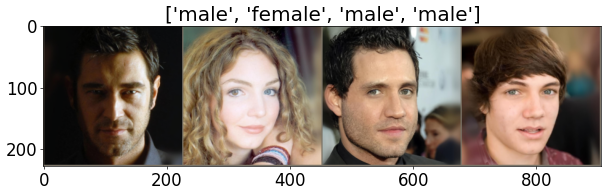

In [ ]:
# Mengatur ukuran dan resolusi dari gambar yang akan ditampilkan
plt.rcParams['figure.figsize'] = [12, 8]  # Ukuran figure (12 x 8 inci)
plt.rcParams['figure.dpi'] = 60           # DPI (dots per inch) untuk resolusi gambar
plt.rcParams.update({'font.size': 20})     # Mengatur ukuran font menjadi 20

# Fungsi untuk menampilkan gambar (imshow)
def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))  # Mengubah tensor dari PyTorch ke numpy array dan menukar dimensi untuk ditampilkan
    # Membalik normalisasi pada gambar agar kembali ke nilai aslinya (undo normalization)
    mean = np.array([0.485, 0.456, 0.406])      # Mean dari normalisasi yang dipakai saat preprocessing
    std = np.array([0.229, 0.224, 0.225])       # Standar deviasi dari normalisasi
    input = std * input + mean                  # Kembalikan gambar ke rentang nilai aslinya
    input = np.clip(input, 0, 1)                # Potong nilai agar tetap berada di antara 0 dan 1 (untuk menyesuaikan batas piksel)
    # Menampilkan gambar menggunakan matplotlib
    plt.imshow(input)
    plt.title(title)                            # Beri judul pada gambar
    plt.show()                                  # Tampilkan gambar

# Mengambil satu batch dari data training
iterator = iter(train_dataloader)  # Membuat iterator dari train_dataloader

# Visualisasi satu batch dari gambar training
inputs, classes = next(iterator)   # Mengambil batch pertama dari iterator (gambar dan label kelas)
out = torchvision.utils.make_grid(inputs[:4])  # Membuat grid dari 4 gambar pertama dalam batch
imshow(out, title=[class_names[x] for x in classes[:4]])  # Menampilkan gambar dengan label kelas yang sesuai


In [ ]:
# Mengimpor model ResNet18 yang telah dilatih sebelumnya
model = models.resnet18(pretrained=True)

num_features = model.fc.in_features  # Mendapatkan jumlah fitur dari layer fully connected (fc) terakhir

model.fc = nn.Linear(num_features, 2)  # Mengganti layer fully connected terakhir untuk binary classification (jumlah kelas = 2)

model = model.to(device)  # Memindahkan model ke perangkat yang ditentukan (CPU/GPU)

criterion = nn.CrossEntropyLoss()  # Mendefinisikan fungsi loss sebagai CrossEntropyLoss, yang sering digunakan untuk klasifikasi
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)# Menggunakan Stochastic Gradient Descent (SGD) sebagai optimizer dengan learning rate 0.001 dan momentum 0.9


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 172MB/s]


In [ ]:
# Jumlah epoch untuk proses training
num_epochs = 5

# Menyimpan waktu mulai training
start_time = time.time()

# Loop untuk setiap epoch
for epoch in range(num_epochs):
    """ Training Phase """
    model.train()  # Mengatur model ke mode training, memungkinkan backpropagation dan update weight

    running_loss = 0.  # Menyimpan akumulasi loss dalam satu epoch
    running_corrects = 0  # Menyimpan jumlah prediksi yang benar dalam satu epoch

    # Loop untuk setiap batch dari train_dataloader
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)  # Memindahkan input (gambar) ke GPU (jika ada)
        labels = labels.to(device)  # Memindahkan label ke GPU (jika ada)

        # Forward pass: hitung output dari model
        optimizer.zero_grad()  # Reset gradient agar tidak terakumulasi
        outputs = model(inputs)  # Mendapatkan output dari model
        _, preds = torch.max(outputs, 1)  # Mendapatkan prediksi dengan nilai terbesar (probabilitas tertinggi)
        loss = criterion(outputs, labels)  # Menghitung loss antara prediksi dan label sebenarnya

        # Backpropagation dan update parameter (weight)
        loss.backward()  # Hitung gradien melalui backpropagation
        optimizer.step()  # Update weight model menggunakan gradien

        # Mengakumulasi total loss dan correct predictions
        running_loss += loss.item() * inputs.size(0)  # Total loss dikali jumlah sample di batch ini
        running_corrects += torch.sum(preds == labels.data)  # Jumlah prediksi yang benar

    # Hitung rata-rata loss dan akurasi untuk satu epoch
    epoch_loss = running_loss / len(train_dataset)  # Rata-rata loss
    epoch_acc = running_corrects / len(train_dataset) * 100.  # Akurasi dalam persentase
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

    """ Test Phase """
    model.eval()  # Mengatur model ke mode evaluasi (tanpa update weight dan disable dropout)

    with torch.no_grad():  # Non-aktifkan gradient computation selama evaluasi (hemat memori & waktu)
        running_loss = 0.
        running_corrects = 0

        # Loop untuk setiap batch dari test_dataloader
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)  # Memindahkan input (gambar) ke GPU
            labels = labels.to(device)  # Memindahkan label ke GPU

            # Forward pass: hitung output dari model tanpa backpropagation
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Mendapatkan prediksi
            loss = criterion(outputs, labels)  # Hitung loss

            # Akumulasi total loss dan correct predictions
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Hitung rata-rata loss dan akurasi untuk test set
        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / len(test_dataset) * 100.
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))


[Train #0] Loss: 0.0949 Acc: 96.3623% Time: 282.8042s
[Test #0] Loss: 0.0653 Acc: 98.0170% Time: 349.5021s
[Train #1] Loss: 0.0434 Acc: 98.5208% Time: 629.9453s
[Test #1] Loss: 0.0480 Acc: 98.3336% Time: 696.4437s
[Train #2] Loss: 0.0285 Acc: 99.0208% Time: 978.3935s
[Test #2] Loss: 0.0424 Acc: 98.4336% Time: 1042.9852s
[Train #3] Loss: 0.0169 Acc: 99.4666% Time: 1317.4460s
[Test #3] Loss: 0.0492 Acc: 98.4003% Time: 1384.0124s
[Train #4] Loss: 0.0120 Acc: 99.6458% Time: 1660.2366s
[Test #4] Loss: 0.0522 Acc: 98.5336% Time: 1727.2425s


In [ ]:
save_path = 'face_gender_classification_transfer_learning_with_ResNet18.pth'
torch.save(model.state_dict(), save_path)

In [ ]:
image_path = 'sri.jpeg'

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-12-6ebe785af38c>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via t

Predicted: Female


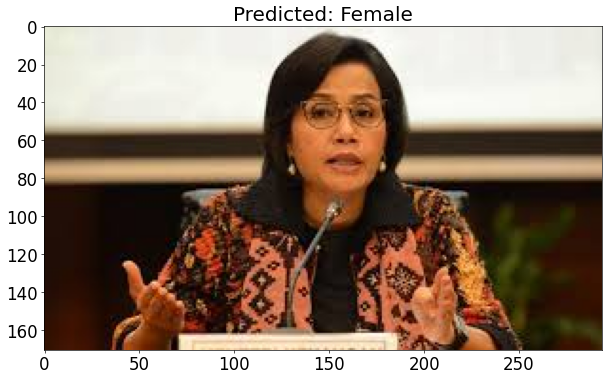

[Test #4] Loss: 0.0522 Acc: 98.5336% Time: 3482.6641s


In [ ]:
# Preprocessing gambar, sesuai dengan transformasi yang dipakai saat training
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),               # Ubah ukuran gambar ke 224x224
    transforms.ToTensor(),                       # Konversi gambar ke tensor
    transforms.Normalize([0.485, 0.456, 0.406],  # Normalisasi (mean & std dari ImageNet)
                         [0.229, 0.224, 0.225])
])

# Muat gambar dari file
image = Image.open(image_path)

# Preprocess gambar
image_tensor = preprocess(image).unsqueeze(0)  # Menambahkan batch dimension di depan

# Pindahkan gambar ke device (GPU/CPU)
image_tensor = image_tensor.to(device)

# Menginisialisasi model GoogleNet dengan pre-trained weights
model = models.resnet18(pretrained=True)

num_features = model.fc.in_features  # Mendapatkan jumlah fitur dari layer fully connected (fc) terakhir

model.fc = nn.Linear(num_features, 2)  # Mengganti layer fully connected terakhir untuk binary classification (jumlah kelas = 2)

model = model.to(device)

model.load_state_dict(torch.load('face_gender_classification_transfer_learning_with_ResNet18.pth'))  # Muat bobot
model = model.to(device)  # Pindahkan model ke device
model.eval()  # Set model ke mode evaluasi

with torch.no_grad():
    outputs = model(image_tensor)  # Forward pass untuk mendapatkan prediksi
    _, preds = torch.max(outputs, 1)  # Mendapatkan prediksi kelas dengan nilai tertinggi

# Tampilkan hasil prediksi
class_names = ['Male', 'Female']  # Misalnya untuk klasifikasi gender
print('Predicted:', class_names[preds.item()])

# Tampilkan hasil prediksi
class_names = ['Male', 'Female']
predicted_label = class_names[preds.item()]
# Plot gambar dan hasil prediksi
plt.imshow(image)
plt.title(f'Predicted: {predicted_label}')
plt.show()
epoch_loss = running_loss / len(test_dataset)
epoch_acc = running_corrects / len(test_dataset) * 100.
print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

<ipython-input-19-8c55c53c5ebd>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('face_gender_classification_transfer_learning_with_ResNet1

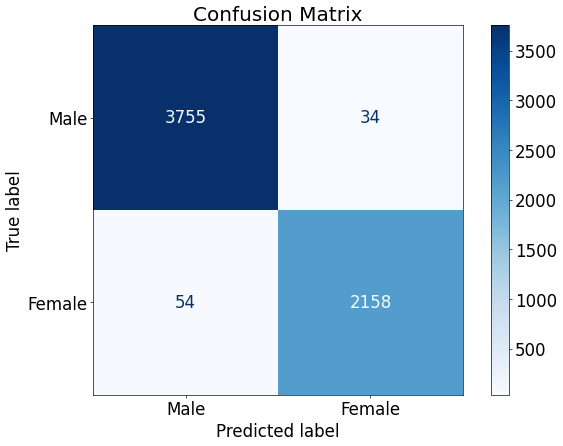

In [ ]:
# Mengimpor model ResNet18 yang telah dilatih sebelumnya
model = models.resnet18(pretrained=True)

num_features = model.fc.in_features  # Mendapatkan jumlah fitur dari layer fully connected (fc) terakhir

model.fc = nn.Linear(num_features, 2)  # Mengganti layer fully connected terakhir untuk binary classification (jumlah kelas = 2)

model = model.to(device)

model.load_state_dict(torch.load('face_gender_classification_transfer_learning_with_ResNet18.pth'))  # Muat bobot
model = model.to(device)  # Pindahkan model ke device
model.eval()  # Set model ke mode evaluasi
all_preds = []
all_labels = []

# Path to the test dataset
test_female_folder = 'CelebA_HQ_face_gender_dataset/test/female'
test_male_folder = 'CelebA_HQ_face_gender_dataset/test/male'

# Load images and their corresponding labels
image_paths = []
true_labels = []

# Load female images
for image_name in os.listdir(test_female_folder):
    image_paths.append(os.path.join(test_female_folder, image_name))
    true_labels.append(0)  # 0 for Female

# Load male images
for image_name in os.listdir(test_male_folder):
    image_paths.append(os.path.join(test_male_folder, image_name))
    true_labels.append(1)  # 1 for Male

# Process each image
for image_path, true_label in zip(image_paths, true_labels):
    image = Image.open(image_path)
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)  # Forward pass untuk mendapatkan prediksi
        _, preds = torch.max(outputs, 1)  # Mendapatkan prediksi kelas dengan nilai tertinggi

    # Simpan hasil prediksi dan label asli
    all_preds.append(preds.item())
    all_labels.append(true_label)

# Hitung dan tampilkan confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])  # Sesuaikan dengan label asli
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()